## Chatbots With Langgraph

In [1]:
!pip install langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.8 MB/s eta 0:00:00


In [2]:
!pip install langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [3]:
from google.colab import userdata #Importing keys
groq_api_key=userdata.get('groq_api_key')
langsmith=userdata.get('LANGSMITH_API_KEY')


In [4]:
import os
#For langSmith
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="CourseLanggraph"

In [5]:
from langchain_groq import ChatGroq

In [6]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f7062b190d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f7062b3a290>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Start Building Chatbot Using Langgraph

In [126]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

In [127]:
class State(TypedDict):
  # in the annotation defines how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
  messages:Annotated[list, add_messages]

In [128]:
graph_builder=StateGraph(State) #graph structure
graph_builder

In [129]:
from langgraph.graph.message import add_messages
from langchain.schema import AIMessage

def chatbot(state: State): #defining node function and passing state to it
    print(state)
    # to llm we are passing the current state. i.e. complete history with current question, since we are appending rather then overwritting.
    return {"messages": [llm.invoke(state["messages"])]}
    # in response the function is returning updated state = current state + LLM response.

In [130]:
graph_builder.add_node("chatbot",chatbot) # added node to graph
graph_builder

In [131]:
graph_builder.add_edge(START,"chatbot") #define relationships
graph_builder.add_edge("chatbot",END)

In [132]:
from langgraph.checkpoint.memory import MemorySaver

graph = graph_builder.compile(checkpointer=MemorySaver()) # compile graph for validating
thread_config = {"configurable": {"thread_id": "1"}}

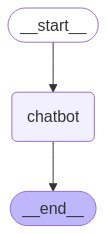

In [133]:
from IPython.display import Image, display #code to display graph
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

## when re-initializing state for each new question

In [134]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}, thread_config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: what is calcules
{'messages': [HumanMessage(content='what is calcules', additional_kwargs={}, response_metadata={}, id='7b3e55c5-0fd7-415d-ad65-553f2b1b4267')]}
Assistant: Calculus is a branch of mathematics that deals with **continuous change**. 

It's essentially the study of:

* **Rates of change:** How things change over time or in relation to other variables (like speed, acceleration, growth rates).
* **Accumulation:** The total effect of continuous change over an interval (like finding the area under a curve).

Calculus has two main branches:

* **Differential Calculus:** Focuses on instantaneous rates of change. Think of it as finding the slope of a curve at a specific point. This helps us understand how things are changing *right now*.

* **Integral Calculus:** Focuses on accumulation. It helps us find the total effect of a continuous change over a given interval. Think of it as finding the area under a curve.

**Why is Calculus Important?**

Calculus is a powerful tool u